# 1. Imports & Data

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import shapiro

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt  


data = pd.read_csv('data_for_train.csv')
if 'Unnamed: 0' in data.columns:
    data = data.drop('Unnamed: 0', axis=1)

data 

,id,date,screen,call,sms,mood,circumplex.arousal,circumplex.valence,activity,appCat.builtin,...,appCat.communication_normalized,appCat.entertainment_normalized,appCat.other_normalized,appCat.social_normalized,day_of_week_sin,day_of_week_cos,month_sin,month_cos,high_activity,mood_category
0,AS14.01,2014-03-30,0.233209,4.2,3.4,7.500000,-0.500000,0.75,0.110931,414.365,...,0.372039,0.439992,0.021203,0.048044,-0.781831,0.623490,1.000000,6.123234e-17,0,high
1,AS14.01,2014-03-31,0.610632,6.0,2.0,7.400000,0.000000,0.60,0.159315,2961.405,...,0.456868,0.150693,0.023008,0.115716,0.000000,1.000000,1.000000,6.123234e-17,0,high
2,AS14.01,2014-04-01,0.886055,1.0,1.6,6.000000,0.200000,0.00,0.267636,1385.517,...,0.445810,0.075378,0.008863,0.368616,0.781831,0.623490,0.866025,-5.000000e-01,0,low
3,AS14.01,2014-04-04,0.638632,2.0,1.0,6.200000,0.200000,0.40,0.286269,1957.829,...,0.487356,0.137382,0.015719,0.185478,-0.433884,-0.900969,0.866025,-5.000000e-01,0,low
4,AS14.01,2014-04-05,0.172171,2.0,3.2,6.800000,-0.400000,0.60,0.268900,15159.190,...,0.107337,0.004348,0.004619,0.020678,-0.974928,-0.222521,0.866025,-5.000000e-01,0,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,AS14.33,2014-05-11,0.275172,3.2,2.8,6.000000,0.000000,0.40,0.025225,259.893,...,0.094652,0.067092,0.010046,0.779455,-0.781831,0.623490,0.500000,-8.660254e-01,0,low
917,AS14.33,2014-05-12,0.800801,1.0,2.0,6.000000,-0.750000,0.50,0.054270,1196.532,...,0.150803,0.067181,0.041487,0.571242,0.000000,1.000000,0.500000,-8.660254e-01,0,low
918,AS14.33,2014-05-13,0.970030,1.0,2.0,5.000000,0.500000,0.00,0.316265,2505.530,...,0.379729,0.107784,0.003460,0.289844,0.781831,0.623490,0.500000,-8.660254e-01,0,low
919,AS14.33,2014-05-14,0.213907,1.6,3.0,6.833333,-0.333333,0.40,0.009006,268.980,...,0.029908,0.203304,0.018769,0.698016,0.974928,-0.222521,0.500000,-8.660254e-01,0,medium


# 2. Prepare features/target & chronological split

In [7]:
data_lstm = data.select_dtypes(include=['float64', 'int64'])


target_column = 'mood'
features = list(data_lstm.columns)
features.remove(target_column)

X = data_lstm[features].values
y = data_lstm[target_column].values


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape to [samples, time steps=1, features]
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Chronological split: Train / Test (80/20) WITHOUT shuffling
X_train, X_test, y_train, y_test = train_test_split(
    X_lstm, y, test_size=0.2, random_state=42, shuffle=False
)


X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.125, random_state=42, shuffle=False
)


X_train.shape, X_val.shape, X_test.shape

((644, 1, 47), (92, 1, 47), (185, 1, 47))

# 3. Baseline LSTM training 

Epoch 1/50
21/21 [==============================] - 4s 39ms/step - loss: 45.7698 - val_loss: 44.7796
Epoch 2/50
21/21 [==============================] - 0s 4ms/step - loss: 31.4566 - val_loss: 18.9175
Epoch 3/50
21/21 [==============================] - 0s 4ms/step - loss: 7.5466 - val_loss: 1.0625
Epoch 4/50
21/21 [==============================] - 0s 4ms/step - loss: 0.7280 - val_loss: 0.3680
Epoch 5/50
21/21 [==============================] - 0s 4ms/step - loss: 0.7186 - val_loss: 0.3553
Epoch 6/50
21/21 [==============================] - 0s 4ms/step - loss: 0.6667 - val_loss: 0.3959
Epoch 7/50
21/21 [==============================] - 0s 4ms/step - loss: 0.7350 - val_loss: 0.3824
Epoch 8/50
21/21 [==============================] - 0s 4ms/step - loss: 0.6280 - val_loss: 0.3680
Epoch 9/50
21/21 [==============================] - 0s 4ms/step - loss: 0.6357 - val_loss: 0.3748
Epoch 10/50
21/21 [==============================] - 0s 3ms/step - loss: 0.6492 - val_loss: 0.3549
Epoch 11/50
21

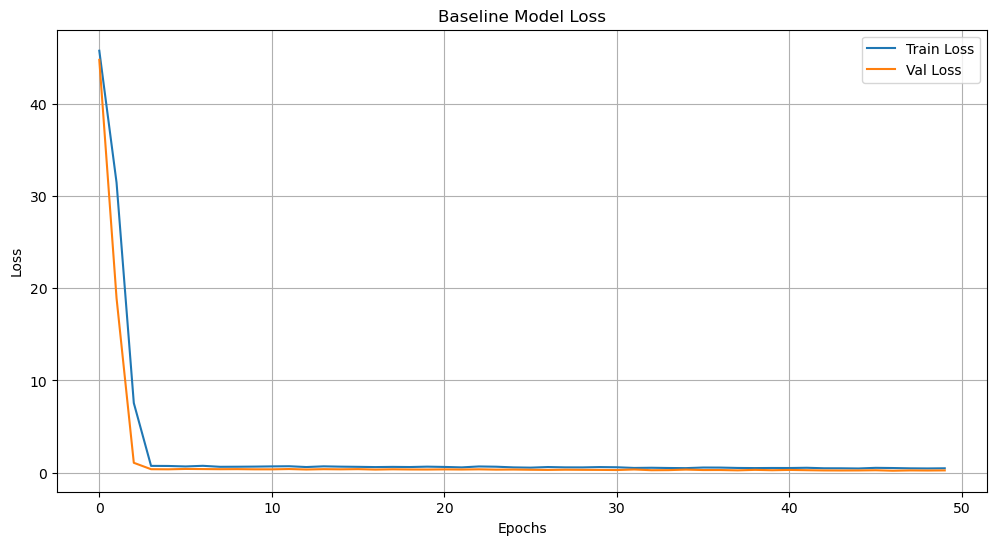

6/6 [==============================] - 1s 2ms/step
Baseline — RMSE: 0.4790 | MAE: 0.3866 | R^2: 0.4575


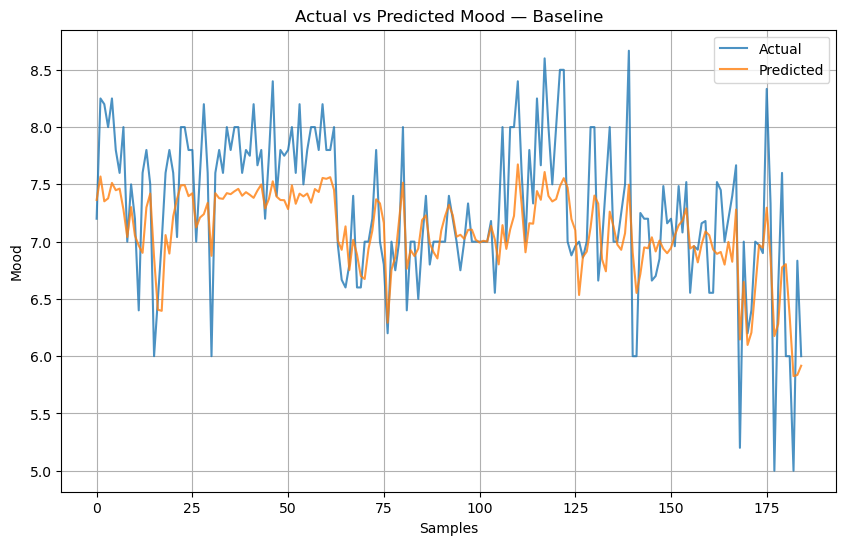

In [10]:
baseline_model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

baseline_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

history = baseline_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1,
    shuffle=False
)

# Plot training history (loss)
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Baseline Model Loss')
plt.ylabel('Loss'); plt.xlabel('Epochs'); plt.legend(loc='upper right'); plt.grid(True)
plt.show()

# Evaluate on Test
y_pred0 = baseline_model.predict(X_test)
rmse0 = np.sqrt(mean_squared_error(y_test, y_pred0))
mae0  = mean_absolute_error(y_test, y_pred0)
r20   = r2_score(y_test, y_pred0)

print(f'Baseline — RMSE: {rmse0:.4f} | MAE: {mae0:.4f} | R^2: {r20:.4f}')

# Plot Actual vs Predicted (Baseline)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', alpha=0.8)
plt.plot(y_pred0, label='Predicted', alpha=0.8)
plt.title('Actual vs Predicted Mood — Baseline')
plt.xlabel('Samples'); plt.ylabel('Mood'); plt.legend(); plt.grid(True)
plt.show()

# 4. EarlyStopping refinement on baseline

Epoch 1/100
21/21 [==============================] - 0s 5ms/step - loss: 0.4042 - val_loss: 0.2273
Epoch 2/100
21/21 [==============================] - 0s 3ms/step - loss: 0.4799 - val_loss: 0.1886
Epoch 3/100
21/21 [==============================] - 0s 3ms/step - loss: 0.4644 - val_loss: 0.2301
Epoch 4/100
21/21 [==============================] - 0s 3ms/step - loss: 0.4872 - val_loss: 0.1965
Epoch 5/100
21/21 [==============================] - 0s 3ms/step - loss: 0.4044 - val_loss: 0.1908
Epoch 6/100
21/21 [==============================] - 0s 3ms/step - loss: 0.4252 - val_loss: 0.1850
Epoch 7/100
21/21 [==============================] - 0s 4ms/step - loss: 0.4153 - val_loss: 0.2174
Epoch 8/100
21/21 [==============================] - 0s 3ms/step - loss: 0.4298 - val_loss: 0.2248
Epoch 9/100
21/21 [==============================] - 0s 3ms/step - loss: 0.4607 - val_loss: 0.1840
Epoch 10/100
21/21 [==============================] - 0s 3ms/step - loss: 0.4075 - val_loss: 0.1870
Epoch 11/

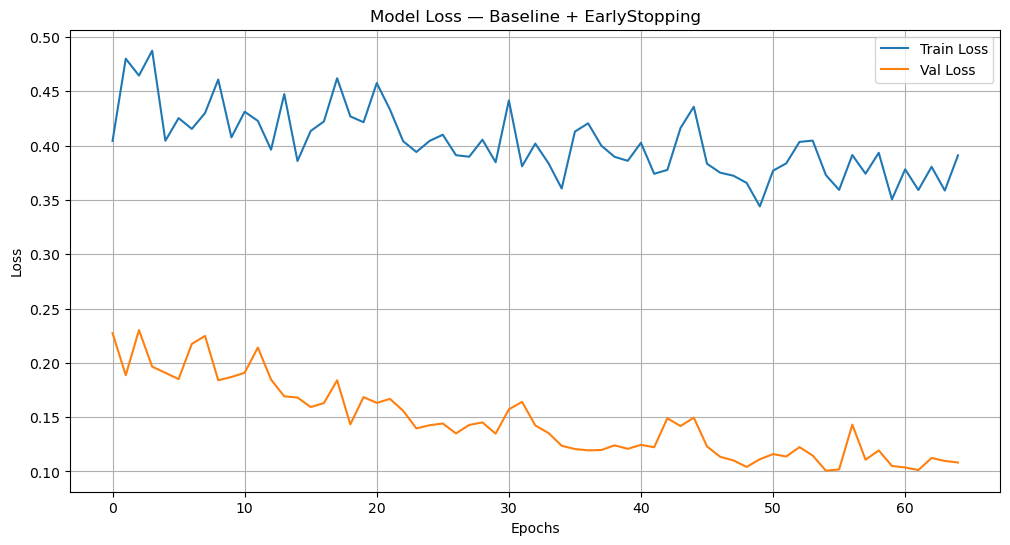

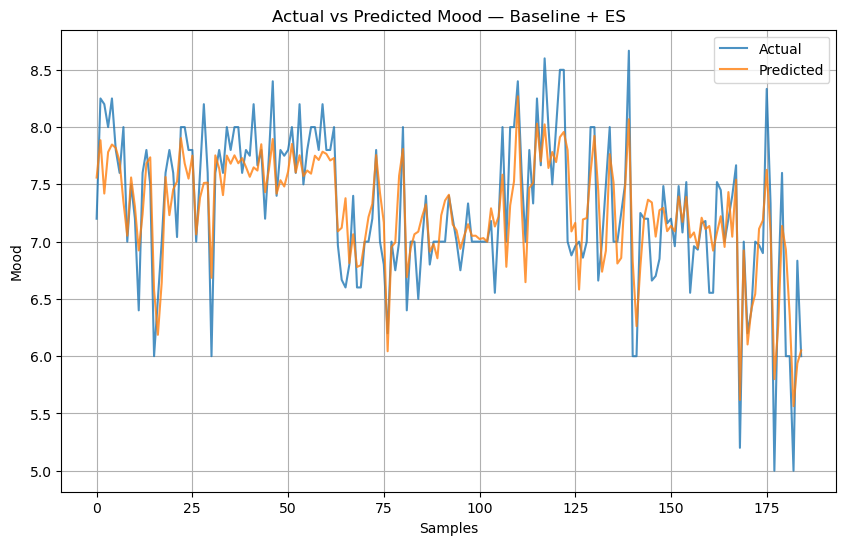

In [13]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_up = baseline_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[es],
    verbose=1,
    shuffle=False
)

y_pred_up = baseline_model.predict(X_test)
rmse_up = np.sqrt(mean_squared_error(y_test, y_pred_up))
mae_up  = mean_absolute_error(y_test, y_pred_up)
r2_up   = r2_score(y_test, y_pred_up)

print(f'Baseline + ES — RMSE: {rmse_up:.4f} | MAE: {mae_up:.4f} | R^2: {r2_up:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(history_up.history['loss'], label='Train Loss')
plt.plot(history_up.history['val_loss'], label='Val Loss')
plt.title('Model Loss — Baseline + EarlyStopping')
plt.ylabel('Loss'); plt.xlabel('Epochs'); plt.legend(loc='upper right'); plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', alpha=0.8)
plt.plot(y_pred_up, label='Predicted', alpha=0.8)
plt.title('Actual vs Predicted Mood — Baseline + ES')
plt.xlabel('Samples'); plt.ylabel('Mood'); plt.legend(); plt.grid(True)
plt.show()

# 5. Another deeper variant

Epoch 1/100
21/21 [==============================] - 6s 55ms/step - loss: 46.6108 - val_loss: 46.1771
Epoch 2/100
21/21 [==============================] - 0s 5ms/step - loss: 27.1609 - val_loss: 5.7692
Epoch 3/100
21/21 [==============================] - 0s 5ms/step - loss: 1.5629 - val_loss: 0.7698
Epoch 4/100
21/21 [==============================] - 0s 5ms/step - loss: 0.9221 - val_loss: 0.5049
Epoch 5/100
21/21 [==============================] - 0s 5ms/step - loss: 0.6404 - val_loss: 0.4263
Epoch 6/100
21/21 [==============================] - 0s 5ms/step - loss: 0.6442 - val_loss: 0.3849
Epoch 7/100
21/21 [==============================] - 0s 5ms/step - loss: 0.6079 - val_loss: 0.3901
Epoch 8/100
21/21 [==============================] - 0s 5ms/step - loss: 0.6698 - val_loss: 0.3901
Epoch 9/100
21/21 [==============================] - 0s 4ms/step - loss: 0.6521 - val_loss: 0.4045
Epoch 10/100
21/21 [==============================] - 0s 5ms/step - loss: 0.6141 - val_loss: 0.3708
Epoch

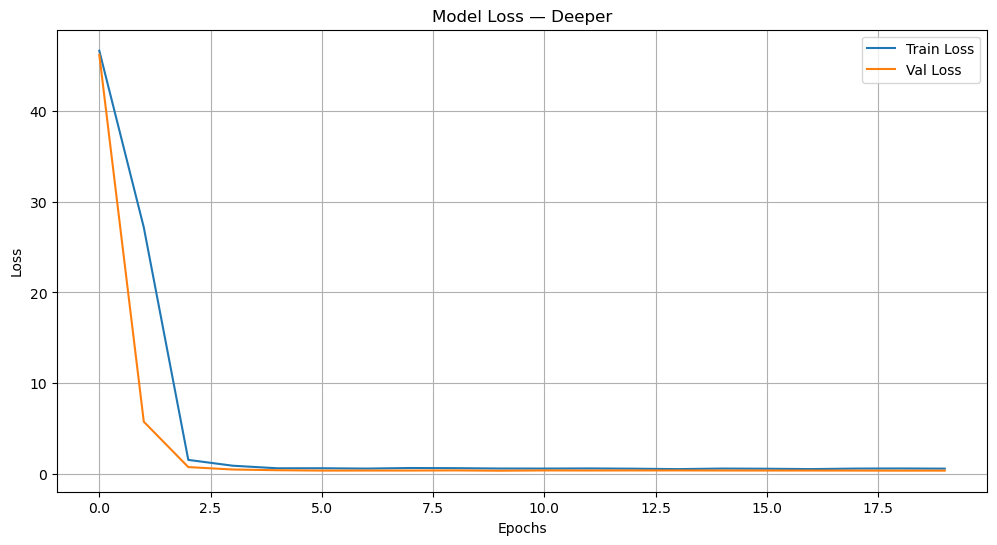

In [16]:
model2 = Sequential()
model2.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(64))
model2.add(Dropout(0.2))
model2.add(Dense(1))

model2.compile(optimizer='adam', loss='mean_squared_error')

es2 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history2 = model2.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[es2],
    verbose=1,
    shuffle=False
)

y_pred2 = model2.predict(X_test)
rmse2 = np.sqrt(mean_squared_error(y_test, y_pred2))
mae2  = mean_absolute_error(y_test, y_pred2)
r22   = r2_score(y_test, y_pred2)

print(f'Deeper — RMSE: {rmse2:.4f} | MAE: {mae2:.4f} | R^2: {r22:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title('Model Loss — Deeper')
plt.ylabel('Loss'); plt.xlabel('Epochs'); plt.legend(loc='upper right'); plt.grid(True)
plt.show()

# 6. Hyperparameter Tuning

In [21]:
def build_model(hp):
    model = Sequential()

    # decide number of layers ONCE
    num_layers = hp.Int('num_layers', min_value=1, max_value=3)

    for i in range(num_layers):
        units = hp.Int(f'units_{i}', min_value=32, max_value=128, step=32)
        return_seq = (i < num_layers - 1)

        if i == 0:
            # set input_shape ONLY on first layer
            model.add(LSTM(units=units,
                           return_sequences=return_seq,
                           input_shape=(X_train.shape[1], X_train.shape[2])))
        else:
            # do NOT pass input_shape on subsequent layers
            model.add(LSTM(units=units, return_sequences=return_seq))

        model.add(Dropout(rate=hp.Float(f'dropout_{i}',
                                        min_value=0.0, max_value=0.5, step=0.05, default=0.25)))

    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='mean_squared_error'
    )
    return model

# Use a fresh project name or overwrite to avoid stale failed trials
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='lstm_regression_tuning_fixed',
    overwrite=True
)

es_tune = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[es_tune],
    verbose=2
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found:")
for k, v in best_hps.values.items():
    print(f" - {k}: {v}")

Trial 10 Complete [00h 00m 16s]
val_loss: 0.41425614058971405

Best val_loss So Far: 0.19061771780252457
Total elapsed time: 00h 02m 58s
Best hyperparameters found:
 - num_layers: 3
 - units_0: 96
 - dropout_0: 0.2
 - learning_rate: 0.0011664403407834704
 - units_1: 96
 - dropout_1: 0.45
 - units_2: 96
 - dropout_2: 0.1


# 7. Build best model 

In [26]:
# Best hyperparameters you found:
best_num_layers = 3
best_units_0    = 96
best_dropout_0  = 0.2
best_units_1    = 96
best_dropout_1  = 0.45
best_units_2    = 96
best_dropout_2  = 0.1
best_lr         = 0.0011664403407834704

best_model = Sequential()
# layer 0
best_model.add(LSTM(best_units_0, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
best_model.add(Dropout(best_dropout_0))
# layer 1
best_model.add(LSTM(best_units_1, return_sequences=True))
best_model.add(Dropout(best_dropout_1))
# layer 2
best_model.add(LSTM(best_units_2, return_sequences=False))
best_model.add(Dropout(best_dropout_2))
# output
best_model.add(Dense(1))

best_model.compile(optimizer=Adam(learning_rate=best_lr), loss='mean_squared_error')

# es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_final = best_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[es],
    verbose=1,
    shuffle=False
)

Epoch 1/200
21/21 [==============================] - 6s 56ms/step - loss: 43.8864 - val_loss: 30.5134
Epoch 2/200
21/21 [==============================] - 0s 6ms/step - loss: 8.0862 - val_loss: 2.0470
Epoch 3/200
21/21 [==============================] - 0s 6ms/step - loss: 1.0503 - val_loss: 0.6650
Epoch 4/200
21/21 [==============================] - 0s 7ms/step - loss: 0.5920 - val_loss: 0.3513
Epoch 5/200
21/21 [==============================] - 0s 7ms/step - loss: 0.5436 - val_loss: 0.3697
Epoch 6/200
21/21 [==============================] - 0s 8ms/step - loss: 0.5125 - val_loss: 0.3747
Epoch 7/200
21/21 [==============================] - 0s 6ms/step - loss: 0.5576 - val_loss: 0.3529
Epoch 8/200
21/21 [==============================] - 0s 6ms/step - loss: 0.5144 - val_loss: 0.3701
Epoch 9/200
21/21 [==============================] - 0s 5ms/step - loss: 0.5282 - val_loss: 0.3613
Epoch 10/200
21/21 [==============================] - 0s 5ms/step - loss: 0.4532 - val_loss: 0.3465
Epoch 

# 8. Evaluate on test + plots

6/6 [==============================] - 1s 2ms/step
Final Tuned — RMSE: 0.2402 | MAE: 0.1803 | R^2: 0.8636


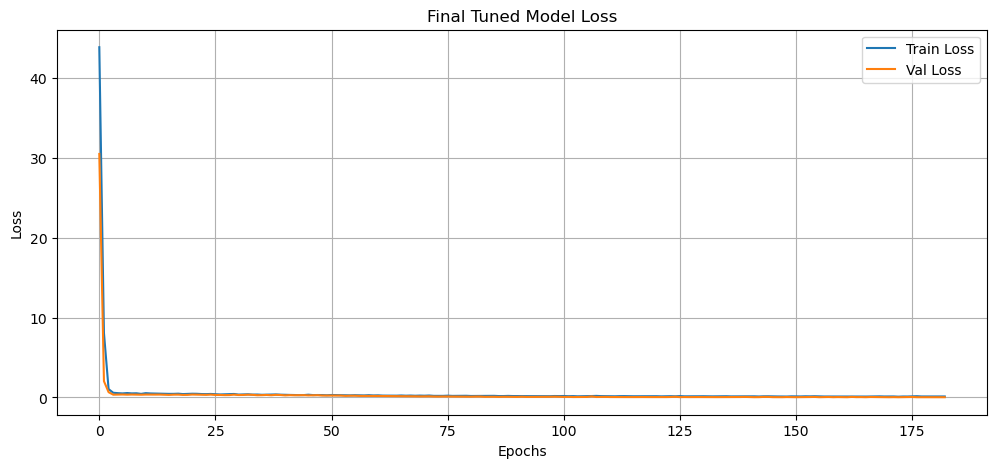

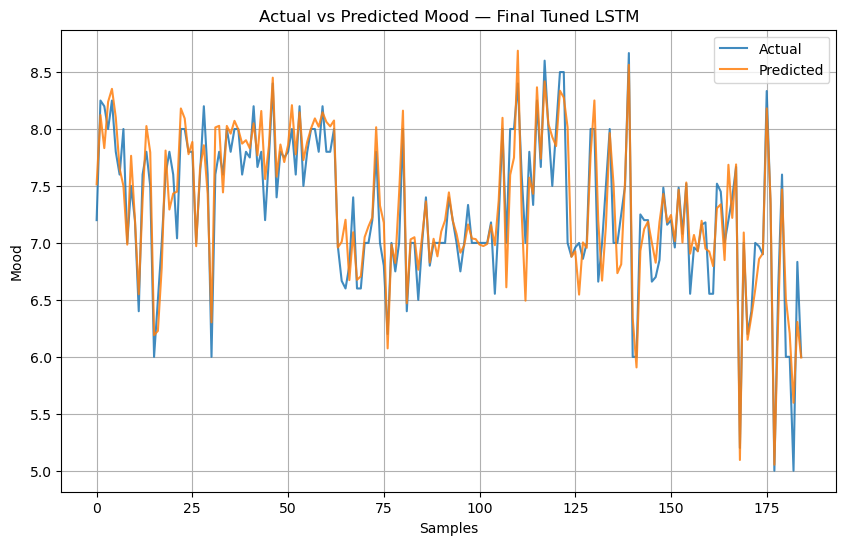

In [29]:
# Predict
y_pred_final = best_model.predict(X_test)

# Metrics
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
mae_final  = mean_absolute_error(y_test, y_pred_final)
r2_final   = r2_score(y_test, y_pred_final)

print(f'Final Tuned — RMSE: {rmse_final:.4f} | MAE: {mae_final:.4f} | R^2: {r2_final:.4f}')

# Loss curves
plt.figure(figsize=(12, 5))
plt.plot(history_final.history['loss'], label='Train Loss')
plt.plot(history_final.history['val_loss'], label='Val Loss')
plt.title('Final Tuned Model Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.show()

# Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', alpha=0.85)
plt.plot(y_pred_final, label='Predicted', alpha=0.85)
plt.title('Actual vs Predicted Mood — Final Tuned LSTM')
plt.xlabel('Samples'); plt.ylabel('Mood'); plt.legend(); plt.grid(True)
plt.show()